In [51]:
import warnings
warnings.filterwarnings("ignore")


# Imports

In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Dataset

In [ ]:


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1) 
x_test = np.expand_dims(x_test, axis=-1) 

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

## Create pairs

In [53]:

def create_pairs(x_data, y_data):
    pairs = []
    labels = []

    digit_indices = [np.where(y_data == i)[0] for i in range(10)]

    for i in range(len(x_data)):
        same_class = random.choice(digit_indices[y_data[i]]) 
        pairs.append([x_data[i], x_data[same_class]]) 
        labels.append(1) 
        diff_class = random.choice([x for x in range(10) if x != y_data[i]])  
        diff_sample = random.choice(digit_indices[diff_class])
        pairs.append([x_data[i], x_data[diff_sample]])  
        labels.append(0)

    return np.array(pairs), np.array(labels)

pairs_train, labels_train = create_pairs(x_train, y_train)

pair1_train = pairs_train[:, 0]
pair2_train = pairs_train[:, 1]

pairs_test, labels_test = create_pairs(x_test, y_test)
pair1_test = pairs_test[:, 0]
pair2_test = pairs_test[:, 1]


## Visualize pairs

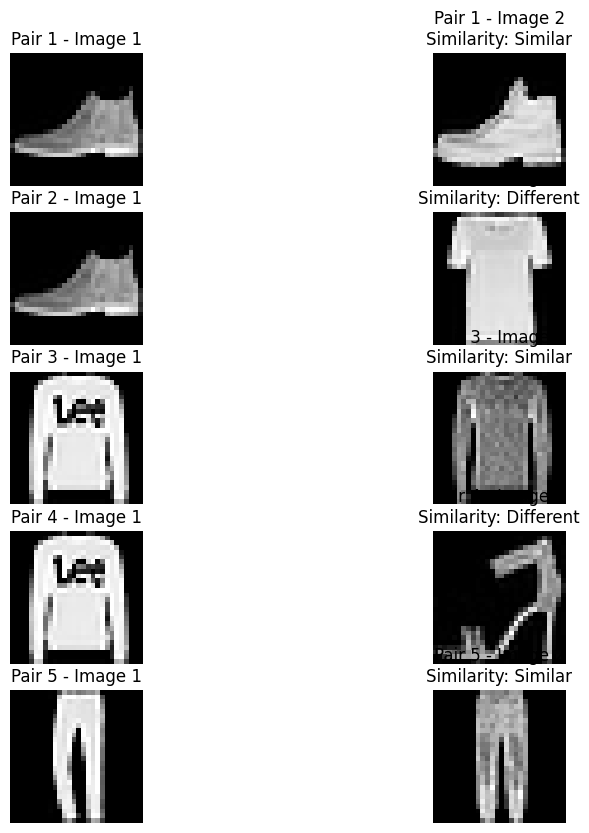

In [54]:

def display_image_pairs(pairs, labels, num_pairs=5):
    plt.figure(figsize=(10, 10))
    
    for i in range(num_pairs):
        ax = plt.subplot(num_pairs, 2, 2*i + 1)
        ax.imshow(pairs[i][0].reshape(28, 28), cmap='gray')
        ax.set_title(f"Pair {i + 1} - Image 1")
        ax.axis('off')
        
        ax = plt.subplot(num_pairs, 2, 2*i + 2)
        ax.imshow(pairs[i][1].reshape(28, 28), cmap='gray')
        ax.set_title(f"Pair {i + 1} - Image 2\nSimilarity: {'Similar' if labels[i] == 1 else 'Different'}")
        ax.axis('off')

    plt.show()
display_image_pairs(pairs_test, labels_test, num_pairs=5)

# Siamese network

In [55]:

def vgg16_siamese(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    
    return model
def create_siamese_model(input_shape):
    base_model = vgg16_siamese(input_shape)
    input1 = layers.Input(input_shape)
    input2 = layers.Input(input_shape)
    feature1 = base_model(input1)
    feature2 = base_model(input2)
    distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]), output_shape=(128,))([feature1, feature2])

    dense = layers.Dense(128, activation='relu')(distance)
    output = layers.Dense(1, activation='sigmoid')(dense) 

    siamese_model = models.Model(inputs=[input1, input2], outputs=output)

    return siamese_model

input_shape = (28, 28, 1) 

siamese_model = create_siamese_model(input_shape)

siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## Train model

In [56]:

history = siamese_model.fit(
    [pair1_train, pair2_train],
    labels_train,                
    epochs=7,                    
    batch_size=128,             
    validation_data=([pair1_test, pair2_test], labels_test)
)


Epoch 1/7
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8288 - loss: 0.3646 - val_accuracy: 0.9031 - val_loss: 0.2339
Epoch 2/7
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9216 - loss: 0.1903 - val_accuracy: 0.9227 - val_loss: 0.1824
Epoch 3/7
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9377 - loss: 0.1531 - val_accuracy: 0.9386 - val_loss: 0.1513
Epoch 4/7
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9481 - loss: 0.1282 - val_accuracy: 0.9389 - val_loss: 0.1543
Epoch 5/7
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9561 - loss: 0.1099 - val_accuracy: 0.9410 - val_loss: 0.1521
Epoch 6/7
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9619 - loss: 0.0960 - val_accuracy: 0.9370 - val_loss: 0.1699
Epoch 7/7
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9668 - loss: 0.0842 - val_accuracy: 0.9449 - val_loss: 0.1499


## Metrics

In [57]:
test_loss, test_accuracy = siamese_model.evaluate([pair1_test, pair2_test], labels_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9428 - loss: 0.1586
Test Loss: 0.1499
Test Accuracy: 0.9449


In [58]:

feature_model = vgg16_siamese(input_shape)
features_train = feature_model.predict(x_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [59]:
len(features_train[0])

128

# t-SNE


In [60]:

tsne = TSNE(n_components=2, random_state=4, n_jobs=-1, verbose=1)
features_tsne = tsne.fit_transform(features_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.004s...
[t-SNE] Computed neighbors for 60000 samples in 14.988s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sa

## Visualisation

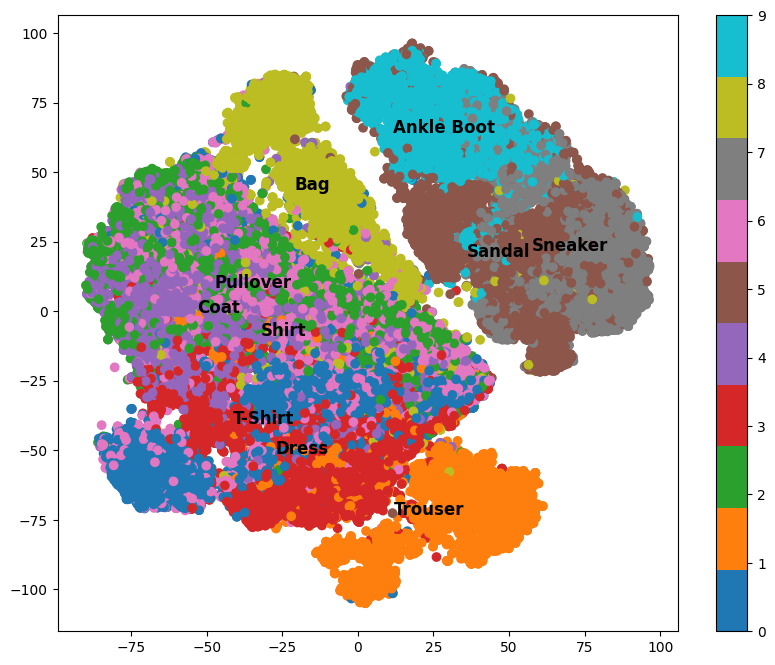

In [73]:

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

plt.figure(figsize=(10, 8))

scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=y_train, cmap='tab10')
plt.colorbar(scatter)

for i in range(10):
    indices = np.where(y_train == i)[0]
    x_mean = np.mean(features_tsne[indices, 0])
    y_mean = np.mean(features_tsne[indices, 1])
    plt.text(x_mean, y_mean, labels_map[i], fontsize=12, ha='center', va='center', fontweight='bold')

plt.title("")
plt.xlabel("")
plt.ylabel("")

plt.show()


# Example of work

In [64]:

def find_similar_images(query_image, x_data, y_data, model, threshold=0.5):
    query_feature = feature_model.predict(np.expand_dims(query_image, axis=0))
    
    similarities = []
    for i in range(len(x_data)):
        feature = feature_model.predict(np.expand_dims(x_data[i], axis=0), verbose=0)
        distance = np.linalg.norm(query_feature - feature) 
        similarities.append((i, distance)) 

    similarities.sort(key=lambda x: x[1])

    similar_images = [x_data[i[0]] for i in similarities[:5]]  
    similar_labels = [y_data[i[0]] for i in similarities[:5]]
    distances = [i[1] for i in similarities[:5]]
    
    return similar_images, similar_labels, distances



## Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


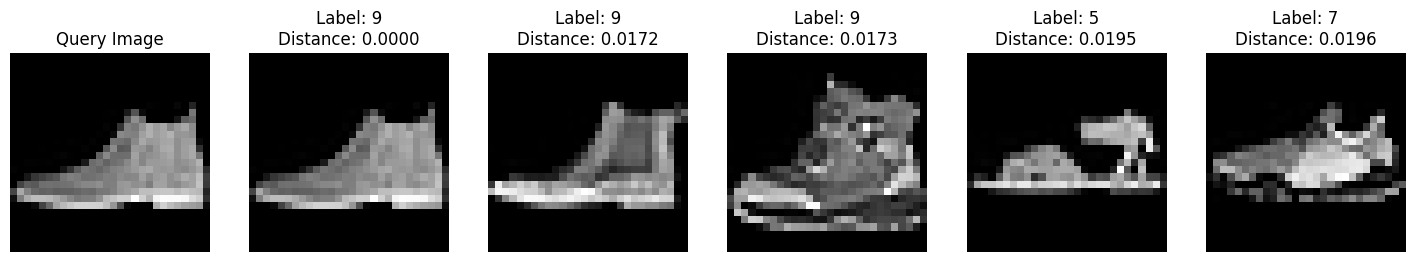

In [65]:

query_image = x_test[0] 

similar_images, similar_labels, distances = find_similar_images(query_image, x_test[:200], y_test[:200], siamese_model)

fig, axes = plt.subplots(1, 6, figsize=(18, 3))
axes[0].imshow(query_image.reshape(28, 28), cmap='gray')
axes[0].set_title(f"Query Image")
axes[0].axis('off')

for i, ax in enumerate(axes[1:]):
    ax.imshow(similar_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {similar_labels[i]}\nDistance: {distances[i]:.4f}")
    ax.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


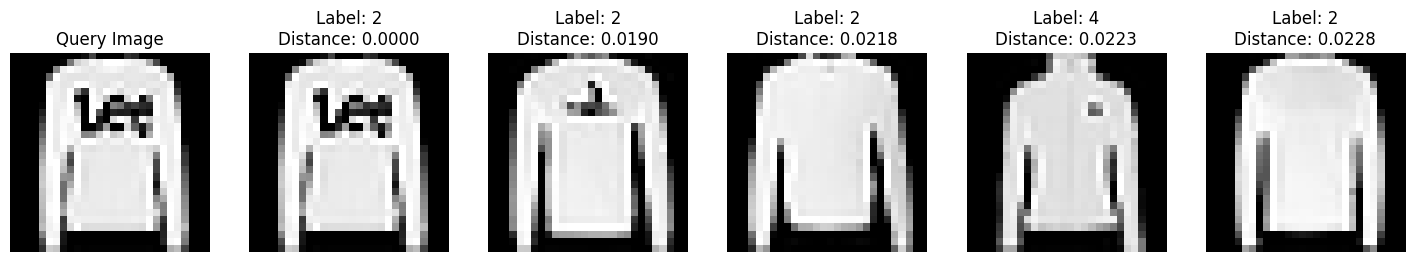

In [67]:

query_image = x_test[1] 

similar_images, similar_labels, distances = find_similar_images(query_image, x_test[:200], y_test[:200], siamese_model)

fig, axes = plt.subplots(1, 6, figsize=(18, 3))
axes[0].imshow(query_image.reshape(28, 28), cmap='gray')
axes[0].set_title(f"Query Image")
axes[0].axis('off')

for i, ax in enumerate(axes[1:]):
    ax.imshow(similar_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {similar_labels[i]}\nDistance: {distances[i]:.4f}")
    ax.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


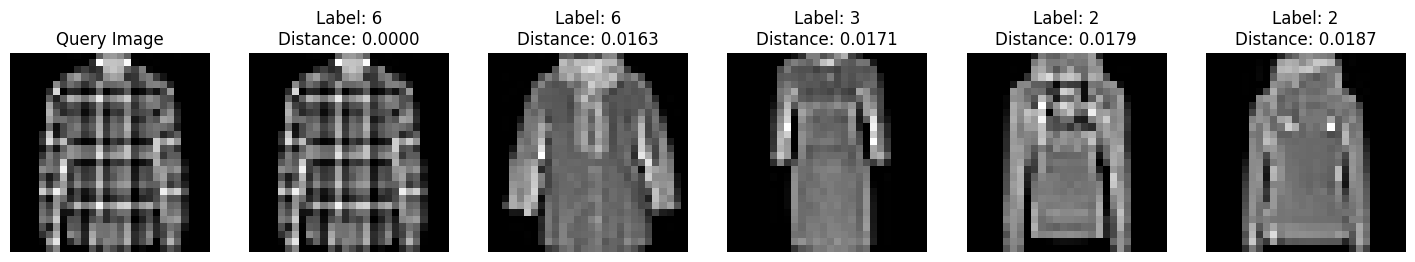

In [72]:

query_image = x_test[7] 

similar_images, similar_labels, distances = find_similar_images(query_image, x_test[:200], y_test[:200], siamese_model)

fig, axes = plt.subplots(1, 6, figsize=(18, 3))
axes[0].imshow(query_image.reshape(28, 28), cmap='gray')
axes[0].set_title(f"Query Image")
axes[0].axis('off')

for i, ax in enumerate(axes[1:]):
    ax.imshow(similar_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {similar_labels[i]}\nDistance: {distances[i]:.4f}")
    ax.axis('off')

plt.show()